In [53]:
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.display import display

%pylab inline
pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [54]:
# Augment Hall of Fame data with name information.

hof_df = pd.read_csv('baseballdatabank-master/core/HallOfFame.csv')
master_df = pd.read_csv('baseballdatabank-master/core/Master.csv')

hof_cols = ['playerID', 'nameFirst', 'nameLast'] + list(hof_df.columns[1:]) 

hof_df = hof_df.merge(master_df, on='playerID')
hof_df = hof_df[hof_cols]

hof_df.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,wagneho01,Honus,Wagner,1936,Veterans,78.0,59.0,5.0,N,Player,NaN
4,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN


In [55]:
# Just want PlayerID and Inducted, remove duplicate No vote records

player_votes = hof_df.loc[(hof_df.category == 'Player')]
inducted_players = hof_df.loc[(hof_df.inducted == 'Y') & (hof_df.category == 'Player')]

non_inducted_ids = set(player_votes.playerID).difference(inducted_players.playerID)

non_inducted_players = player_votes.loc[hof_df.playerID.isin(non_inducted_ids)]
non_inducted_players = non_inducted_players.groupby('playerID', as_index=False).last()

nominated_players = inducted_players.append(non_inducted_players, ignore_index=True)
display(nominated_players.shape)

(1188, 11)

In [62]:
def cumulative_stats(csv_path, display_head=True):
    df = pd.read_csv(csv_path)
    
    if display_head == True:
        display(df.head())
    
    df_total = df.groupby('playerID', as_index=False).sum()
    del df_total['yearID']
    return df_total

# Merge with Appearances
appearances_total = cumulative_stats("baseballdatabank-master/core/Appearances.csv")

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,BS1,NaN,barnero01,31.0,NaN,31,31.0,0,0,0,16,0,15,0,0,0,0,NaN,NaN,NaN
1,1871,BS1,NaN,barrofr01,18.0,NaN,18,18.0,0,0,0,1,0,0,13,0,4,17,NaN,NaN,NaN
2,1871,BS1,NaN,birdsda01,29.0,NaN,29,29.0,0,7,0,0,0,0,0,0,27,27,NaN,NaN,NaN
3,1871,BS1,NaN,conefr01,19.0,NaN,19,19.0,0,0,0,0,0,0,18,0,1,18,NaN,NaN,NaN
4,1871,BS1,NaN,gouldch01,31.0,NaN,31,31.0,0,0,30,0,0,0,0,0,1,1,NaN,NaN,NaN


In [57]:
nominated_players = pd.merge(nominated_players, appearances_total, on='playerID')

position_cols = ['G_p','G_c','G_1b','G_2b',
                 'G_3b','G_ss','G_lf','G_cf',
                 'G_rf','G_of','G_dh','G_ph','G_pr']

def most_played_position(df):
    return df[position_cols].idxmax(axis=1).str.split('_').str[1].str.upper()

nominated_players.insert(3, 'Position', most_played_position(nominated_players))
display(nominated_players.head())

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN,3034.0,NaN,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,NaN,NaN,NaN
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN,2503.0,NaN,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,NaN,NaN,NaN
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN,2794.0,NaN,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,NaN,NaN,NaN
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN,647.0,NaN,647,647.0,636,0,3,0,0,0,1,0,3,4,NaN,NaN,NaN
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN,934.0,NaN,934,934.0,802,0,0,0,0,0,2,7,4,13,NaN,NaN,NaN


In [58]:
# Convert inducted Y/N to numeric for corrplot later
def convert_inducted_to_numeric(s):
    if s == 'Y':
        return 1
    else:
        return 0

nominated_players['inducted'] = nominated_players['inducted'].apply(convert_inducted_to_numeric)

# Pitching

In [69]:
# Merge with Pitching
pitching_total = cumulative_stats("baseballdatabank-master/core/Pitching.csv", display_head=False)

pitchers = nominated_players.loc[nominated_players.Position == 'P']
pitchers = pd.merge(pitchers, pitching_total, on='playerID')

pitchers.head()

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,G_all,GS_x,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,stint,W,L,G,GS_y,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,1,Player,NaN,647.0,NaN,647,647.0,636,0,3,0,0,0,1,0,3,4,NaN,NaN,NaN,19,373,188,635,551,434,79,28,14342.0,4218,1133,91,844,2502,4.37,47.68,NaN,114.0,59.0,6,19136.0,74.0,1616,NaN,NaN,NaN
1,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,1,Player,NaN,934.0,NaN,934,934.0,802,0,0,0,0,0,2,7,4,13,NaN,NaN,NaN,21,417,279,802,666,531,110,34,17744.0,4913,1424,97,1363,3509,4.76,49.31,NaN,155.0,203.0,4,23749.0,129.0,1902,NaN,NaN,NaN
2,youngcy01,Cy,Young,P,1937,BBWAA,201.0,151.0,153.0,1,Player,NaN,918.0,NaN,918,918.0,906,0,5,0,0,0,0,0,0,0,NaN,NaN,NaN,24,511,316,906,815,749,76,17,22064.0,7092,2147,138,1217,2803,5.72,62.42,NaN,156.0,163.0,3,30058.0,84.0,3167,NaN,NaN,NaN
3,alexape01,Pete,Alexander,P,1938,BBWAA,262.0,197.0,212.0,1,Player,NaN,703.0,NaN,703,703.0,696,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,22,373,208,696,599,437,90,32,15570.0,4868,1476,164,951,2198,5.33,62.42,NaN,39.0,70.0,1,20928.0,80.0,1851,NaN,NaN,NaN
4,wadderu01,Rube,Waddell,P,1946,Old Timers,NaN,NaN,NaN,1,Player,NaN,410.0,NaN,410,410.0,407,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,15,193,143,407,340,261,50,5,8884.0,2460,711,37,803,2316,3.30,40.62,NaN,77.0,117.0,4,12101.0,53.0,1063,NaN,NaN,NaN


In [71]:
#pitching_corr = pitchers[['G_all', 'inducted']].corr()
#pitching_corr

,G_all,inducted
G_all,1.000000,0.261107
inducted,0.261107,1.000000


In [73]:
def corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, xticklabels=corr.columns.values, 
                yticklabels=corr.columns.values,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

    ax.set_title("Correlation plot");

,G_all,W,inducted
G_all,1.000000,0.297535,0.261107
W,0.297535,1.000000,0.611305
inducted,0.261107,0.611305,1.000000


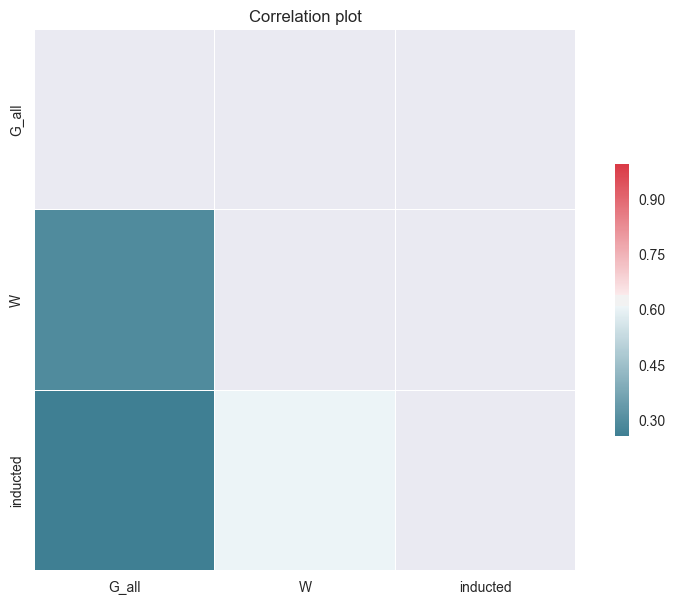

In [78]:
display(pitchers[['G_all', 'W', 'inducted']].corr())
corr_plot(pitchers[['G_all', 'W', 'inducted']].corr())

In [60]:
# Merge with Batting


In [61]:
# Merge with Awards